In [64]:
import os
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

## Dataset Explanation

**About the Dataset:**  
The Stanford Dogs dataset contains images of 120 breeds of dogs from around the world. This dataset has been built using images and annotation from ImageNet for the task of fine-grained image categorization. It was originally collected for fine-grain image categorization, a challenging problem as certain dog breeds have near identical features or differ in colour and age.

**Content:**

- **Number of categories:** 120
- **Number of images:** 20,580
- **Annotations:** Class labels, Bounding boxes

**Acknowledgments:**  
The original data source is found on [Stanford Vision Lab](http://vision.stanford.edu/aditya86/ImageNetDogs/) and contains additional information on the train/test splits and baseline results.

**Citation:**  
Aditya Khosla, Nityananda Jayadevaprakash, Bangpeng Yao and Li Fei-Fei. Novel dataset for Fine-Grained Image Categorization. First Workshop on Fine-Grained Visual Categorization (FGVC), IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2011.

**Citation:**  
Jessica LI. (2019). Stanford Dogs Dataset. [Kaggle Dataset](https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset)

## Feature extraction with data augmentation

In [65]:
# Set the path to the Stanford Dogs Dataset
train_dir = './cropped/train/'
test_dir = './cropped/test/'

In [66]:
# Create a list to store the breed labels
breed_labels = []

for dog_label in os.listdir(train_dir):
    breed_labels.append(dog_label)

breed_labels = breed_labels[:10]
print(breed_labels)

['n02097658-silky_terrier', 'n02092002-Scottish_deerhound', 'n02099849-Chesapeake_Bay_retriever', 'n02091244-Ibizan_hound', 'n02095314-wire-haired_fox_terrier', 'n02091831-Saluki', 'n02102318-cocker_spaniel', 'n02104365-schipperke', 'n02090622-borzoi', 'n02113023-Pembroke']


In [98]:
# First, we define an ImageDataGenerator for augmenting training images to improve the model performance
# By adding different parameters to the ImageDataGenerator, we can apply different transformations to the images

train_datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range = 0.2, 
    zoom_range = 0.2,  
    horizontal_flip = True,  
    fill_mode = 'nearest',
    validation_split = 0.2,
    preprocessing_function=keras.applications.xception.preprocess_input
)

# Generator for the training data
train_generator = train_datagen.flow_from_directory(
    directory = train_dir,
    target_size = (224, 224),
    batch_size = 32,
    classes = breed_labels,
    subset = 'training'  # Use the 'training' subset (80% of the data)
)

# Generator for the validation data
validation_generator = train_datagen.flow_from_directory(
    directory = train_dir,
    target_size = (224, 224),
    batch_size = 32,
    classes = breed_labels,
    subset = 'validation'  # Use the 'validation' subset (20% of the data)
)

test_generator = ImageDataGenerator(
    preprocessing_function=keras.applications.xception.preprocess_input
)

test_generator = test_generator.flow_from_directory(
    directory = test_dir,
    target_size = (224, 224),
    batch_size = 32,
    classes = breed_labels
)

Found 800 images belonging to 10 classes.
Found 200 images belonging to 10 classes.
Found 772 images belonging to 10 classes.


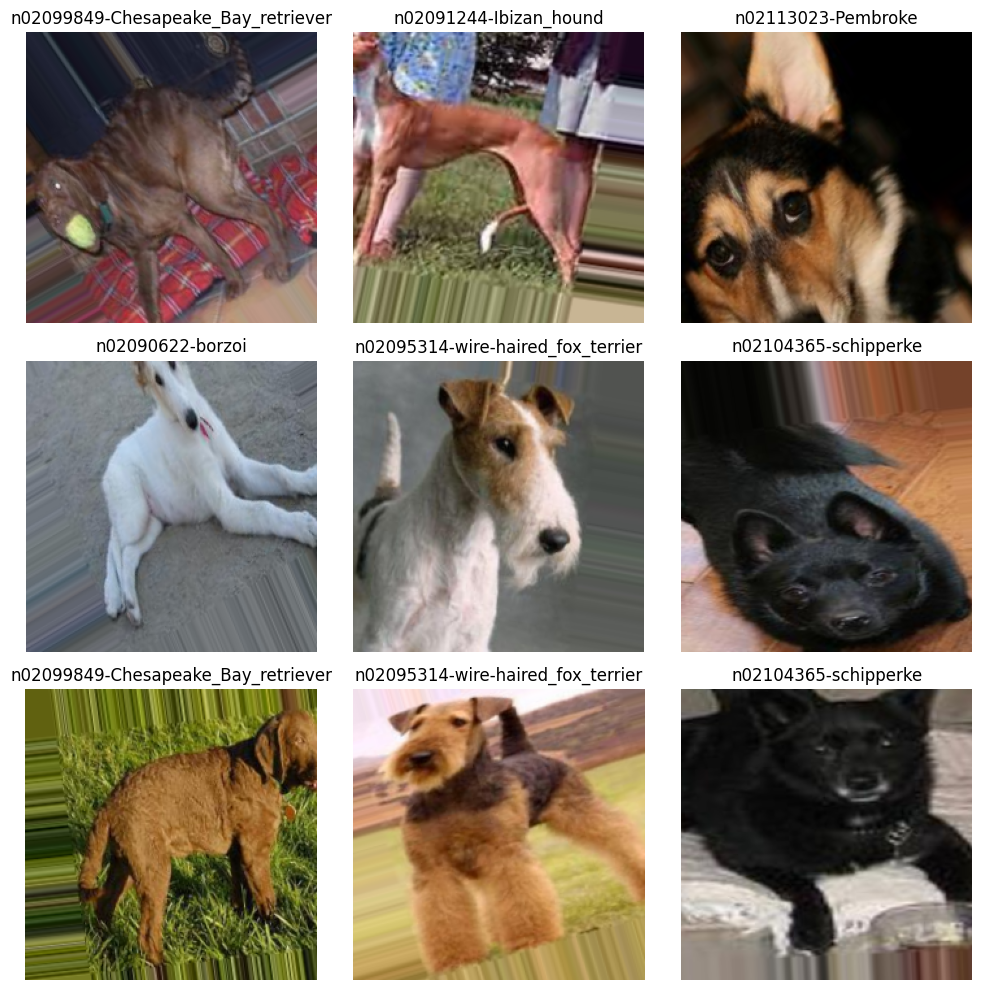

In [99]:
# Get a batch of augmented images and labels
augmented_images, augmented_labels = next(train_generator)

# Since the values of augmented images are between -1 and +1, we need to rescale them to a range between 0 and 1
# This is because the imshow() function expects pixel values to be between 0 and 1 for floats and between 0 and 255 for integers 
augmented_images = (augmented_images + 1) / 2

# Plot the augmented images
fig, axes = plt.subplots(3, 3, figsize=(10,10))
axes = axes.ravel()

for i in range(9):
    axes[i].imshow(augmented_images[i])
    axes[i].set_title(breed_labels[np.argmax(augmented_labels[i])])  # Add the label as the title
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [100]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D, Activation, BatchNormalization

# Dense layers are fully connected layers
# Conv2D layers are convolutional layers for images
# MaxPooling2D layers are pooling layers that condense the images checking the maximum value in a window of pixels and keeping that value
# Dense layers are fully connected layers
# Flatten layers flatten the input to a 1D array to be fed into the dense layers
# Dropout layers randomly drop some of the connections between layers to avoid overfitting

xception_model = keras.applications.xception.Xception(
    weights='imagenet',
    include_top=False, 
    pooling='avg',
    input_shape=(299,299,3))

# look at the differents layers
print("-" * 50)
print("Xception base model layers :")
print("-" * 50)
for layer in xception_model.layers:
    print(layer)

--------------------------------------------------
Xception base model layers :
--------------------------------------------------


In [101]:
for layer in xception_model.layers:
    layer.trainable = False

In [102]:
# Add new fully-connected layers
base_output = xception_model.output
base_output = Dense(128, activation='relu')(base_output)
base_output = Dropout(0.2)(base_output)
# Output : new classifier
predictions = Dense(len(breed_labels), activation='softmax')(base_output)

# Define new model
my_xcept_model = keras.Model(inputs=xception_model.input,
                       outputs=predictions)
my_xcept_model.compile(optimizer="adam",
                       loss="categorical_crossentropy",
                       metrics=[
                            "categorical_accuracy",
                            keras.metrics.Precision(name='precision'),
                            keras.metrics.Recall(name='recall')
                          ])
                       

In [103]:
history = my_xcept_model.fit(train_generator, 
                             epochs=10, 
                             validation_data=validation_generator)

Epoch 1/10
25/25 [==============================] - 16s 528ms/step - loss: 0.6243 - categorical_accuracy: 0.8150 - precision: 0.9550 - recall: 0.7163 - val_loss: 0.0980 - val_categorical_accuracy: 0.9750 - val_precision: 0.9847 - val_recall: 0.9650
Epoch 2/10
25/25 [==============================] - 11s 448ms/step - loss: 0.1512 - categorical_accuracy: 0.9500 - precision: 0.9630 - recall: 0.9438 - val_loss: 0.1091 - val_categorical_accuracy: 0.9550 - val_precision: 0.9692 - val_recall: 0.9450
Epoch 3/10
25/25 [==============================] - 12s 478ms/step - loss: 0.1110 - categorical_accuracy: 0.9613 - precision: 0.9745 - recall: 0.9550 - val_loss: 0.0506 - val_categorical_accuracy: 0.9850 - val_precision: 0.9848 - val_recall: 0.9750
Epoch 4/10
25/25 [==============================] - 12s 464ms/step - loss: 0.1207 - categorical_accuracy: 0.9613 - precision: 0.9708 - recall: 0.9550 - val_loss: 0.0618 - val_categorical_accuracy: 0.9850 - val_precision: 0.9850 - val_recall: 0.9850
Epoc

loss: 0.047797564417123795
categorical_accuracy: 0.9837499856948853
precision: 0.9886792302131653
recall: 0.9825000166893005
val_loss: 0.08298005163669586
val_categorical_accuracy: 0.9700000286102295
val_precision: 0.9797979593276978
val_recall: 0.9700000286102295


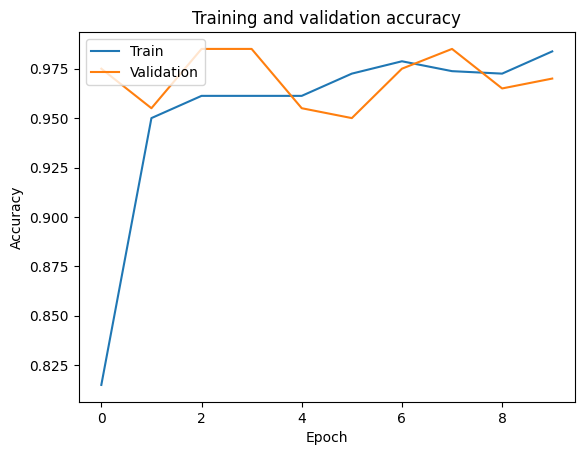

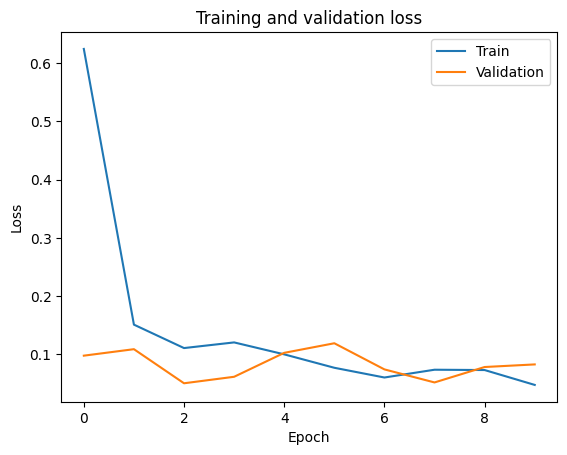

In [104]:
# Print the metrics
for metric in history.history.keys():
    print(f"{metric}: {history.history[metric][-1]}")

# Plot the training and validation accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [105]:
# Evaluate the model on the test set
test_loss, test_acc, test_precision, test_recall = my_xcept_model.evaluate(test_generator)

print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

25/25 [==============================] - 9s 352ms/step - loss: 0.0381 - categorical_accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883
Test accuracy: 0.9883419871330261
Test loss: 0.038052309304475784


In [106]:
from sklearn.metrics import classification_report

# Get the true labels and predicted labels
true_labels = test_generator.classes
predicted_labels = my_xcept_model.predict(test_generator).argmax(axis=1)

# Print the classification report
print(classification_report(true_labels, predicted_labels, target_names=breed_labels))


25/25 [==============================] - 11s 371ms/step
                                    precision    recall  f1-score   support

           n02097658-silky_terrier       0.12      0.12      0.12        83
      n02092002-Scottish_deerhound       0.20      0.20      0.20       132
n02099849-Chesapeake_Bay_retriever       0.09      0.09      0.09        67
            n02091244-Ibizan_hound       0.15      0.15      0.15        88
 n02095314-wire-haired_fox_terrier       0.05      0.05      0.05        57
                  n02091831-Saluki       0.17      0.17      0.17       100
          n02102318-cocker_spaniel       0.05      0.05      0.05        59
              n02104365-schipperke       0.04      0.04      0.04        54
                  n02090622-borzoi       0.04      0.04      0.04        51
                n02113023-Pembroke       0.14      0.15      0.15        81

                          accuracy                           0.12       772
                         macro

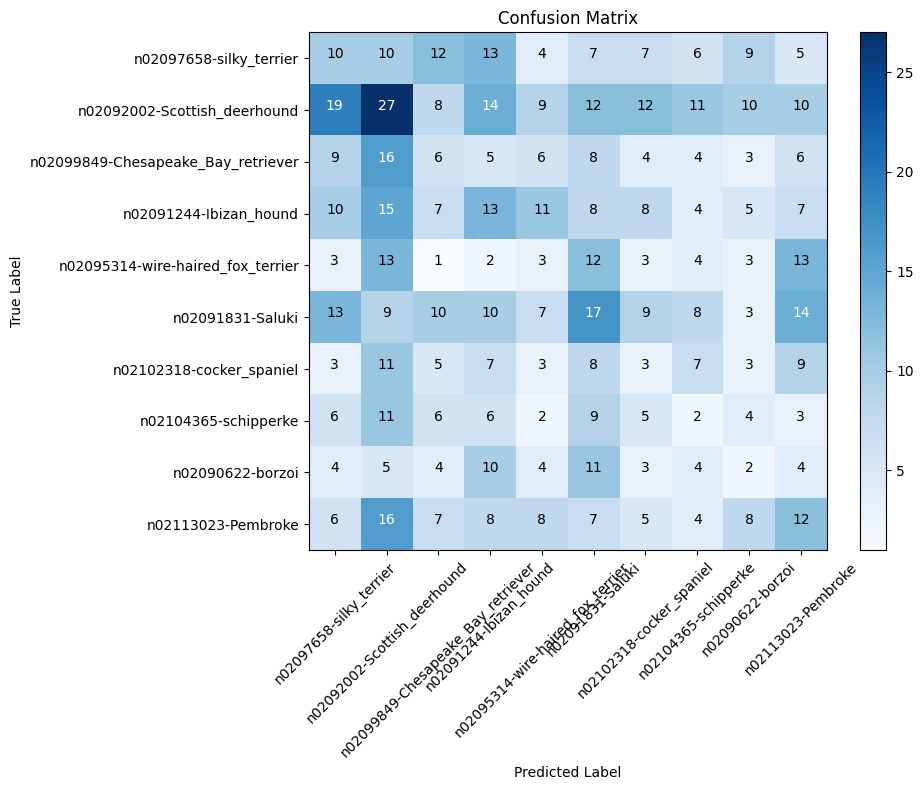

In [107]:
from sklearn.metrics import confusion_matrix

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(breed_labels))
plt.xticks(tick_marks, breed_labels, rotation=45)
plt.yticks(tick_marks, breed_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add the count values in each cell
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()
